In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [2]:
from datasets import load_dataset

# Download and load the MSLR-WEB10K dataset directly from Hugging Face
print("Loading MSLR-WEB10k dataset from Hugging Face...")
dataset = load_dataset("philipphager/MSLR-WEB10k")

# Convert to pandas DataFrames for easier manipulation
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

print(f"Dataset loaded successfully!")
print(f"Training set: {len(train_df)} queries")
print(f"Validation set: {len(val_df)} queries")
print(f"Test set: {len(test_df)} queries")

Loading MSLR-WEB10k dataset from Hugging Face...


train.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/86.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset loaded successfully!
Training set: 6000 queries
Validation set: 2000 queries
Test set: 2000 queries


In [3]:
# @title Exploring dataset
train_df.head()

,query,labels,features,n
0,1,"[2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[[3.0, 3.0, 0.0, 0.0, 3.0, 1.0, 1.0, 0.0, 0.0,...",86
1,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, ...","[[3.0, 0.0, 2.0, 0.0, 3.0, 1.0, 0.0, 0.666667,...",103
2,7,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[2.0, 0.0, 2.0, 0.0, 2.0, 0.666667, 0.0, 0.66...",111
3,16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",106
4,19,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, ...","[[2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0,...",76


In [4]:
def get_label_distribution(df):
    all_labels = []
    for label in df['labels']:
        all_labels.extend(label)
    all_labels = np.array(all_labels)
    unique, counts = np.unique(all_labels, return_counts=True)
    return unique, counts

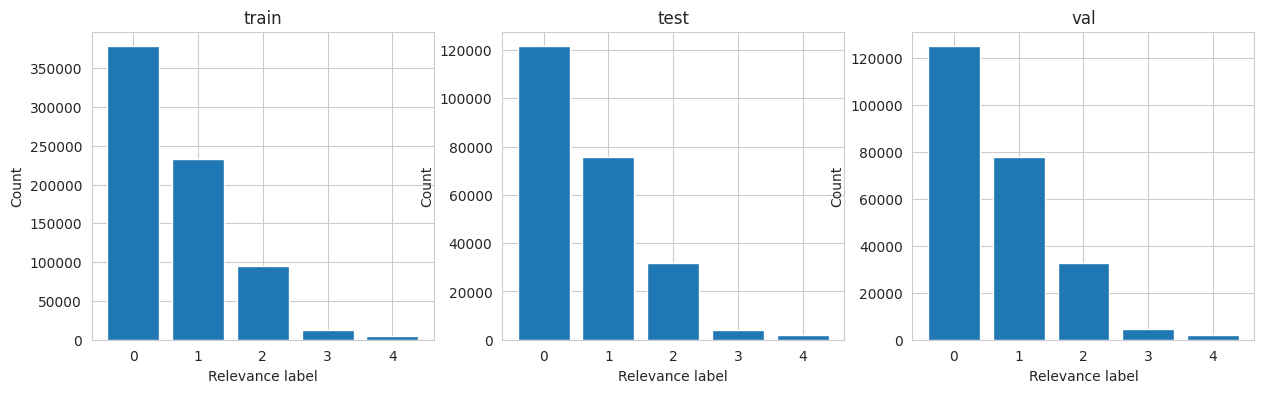

In [5]:
train_labels, train_count = get_label_distribution(train_df)
val_labels, val_count = get_label_distribution(val_df)
test_labels, test_count = get_label_distribution(test_df)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for axis, data, title in zip(axes, [(train_labels, train_count), (val_labels, val_count), (test_labels, test_count)], [
    'train', 'test', 'val'
]):
    axis.set_title(title)
    axis.set_xlabel('Relevance label')
    axis.set_ylabel('Count')
    axis.bar(data[0], data[1])

plt.show()

In [6]:
train_df['n'].describe()

count    6000.000000
mean      120.568667
std        70.153966
min         1.000000
25%        77.000000
50%       110.000000
75%       152.000000
max       809.000000
Name: n, dtype: float64

In [7]:
class RankingDataset(Dataset):
    def __init__(self, df, feature_norm='standard'):
        self.queries = []
        self.all_features = []
        self.all_labels = []

        # Process each query
        for idx, row in df.iterrows():
            features = np.stack(row['features'])  # Shape: (n_docs, n_features)
            labels = row['labels']

            self.queries.append({
                'query_id': row['query'],
                'features': features,
                'labels': labels,
                'n_docs': row['n']
            })

            self.all_features.append(features)
            self.all_labels.extend(labels)

        # Compute normalization statistics
        all_features_concat = np.vstack(self.all_features)

        if feature_norm == 'standard':
            self.feature_mean = np.mean(all_features_concat, axis=0)
            self.feature_std = np.std(all_features_concat, axis=0) + 1e-6
        elif feature_norm == 'minmax':
            self.feature_min = np.min(all_features_concat, axis=0)
            self.feature_max = np.max(all_features_concat, axis=0)
            self.feature_range = self.feature_max - self.feature_min + 1e-6

        self.feature_norm = feature_norm
        self.feature_dim = all_features_concat.shape[1]

        print(f"Dataset created: {len(self.queries)} queries, {len(self.all_labels)} documents")
        print(f"Feature dimension: {self.feature_dim}")

    def normalize_features(self, features):
        if self.feature_norm == 'standard':
            return (features - self.feature_mean) / self.feature_std
        elif self.feature_norm == 'minmax':
            return (features - self.feature_min) / self.feature_range
        else:
            return features

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        query = self.queries[idx]
        features = self.normalize_features(query['features'])

        return {
            'query_id': query['query_id'],
            'features': torch.FloatTensor(features),
            'labels': torch.FloatTensor(query['labels']),
            'n_docs': query['n_docs']
        }

# Create datasets
train_dataset = RankingDataset(train_df, feature_norm='standard')
val_dataset = RankingDataset(val_df, feature_norm='standard')
test_dataset = RankingDataset(test_df, feature_norm='standard')

# Apply same normalization to validation and test
val_dataset.feature_mean = train_dataset.feature_mean
val_dataset.feature_std = train_dataset.feature_std
test_dataset.feature_mean = train_dataset.feature_mean
test_dataset.feature_std = train_dataset.feature_std

Dataset created: 6000 queries, 723412 documents
Feature dimension: 136
Dataset created: 2000 queries, 235259 documents
Feature dimension: 136
Dataset created: 2000 queries, 241521 documents
Feature dimension: 136


In [8]:
class RankNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.2):
        super(RankNet, self).__init__()

        layers = []
        prev_dim = input_dim

        # Build layers without BatchNorm to avoid single-sample issues
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        # Final scoring layer
        layers.append(nn.Linear(prev_dim, 1))

        self.model = nn.Sequential(*layers)

        # Feature attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(input_dim, max(input_dim // 4, 16)),
            nn.ReLU(),
            nn.Linear(max(input_dim // 4, 16), input_dim),
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        # Apply attention to features
        attention_weights = self.attention(x)
        x = x * attention_weights

        # Get relevance scores
        scores = self.model(x)
        return scores.squeeze(-1)

# Initialize model
model = RankNet(input_dim=train_dataset.feature_dim, 
                hidden_dims=[512, 256, 128, 64],
                dropout=0.3)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")
print(f"\nModel architecture:")
print(model)

Model parameters: 252,107

Model architecture:
RankNet(
  (model): Sequential(
    (0): Linear(in_features=136, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
  (attention): Sequential(
    (0): Linear(in_features=136, out_features=34, bias=True)
    (1): ReLU()
    (2): Linear(in_features=34, out_features=136, bias=True)
    (3): Sigmoid()
  )
)
